**Import libraries and define system parameters**

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cvx
from utils import calculate_num_sensors, calculate_graph_matrices, is_graph_connected, get_field_function, get_sensor_measurements, visualize_graphs 
from utils import calculate_error, get_W_bar

FIELD_SIZE = 100
FIELD_RANGE = np.array([[0, FIELD_SIZE], [0, FIELD_SIZE]])

# True measurement function
field_function = get_field_function()

COMM_RANGE = 30
NUM_SENSORS = calculate_num_sensors(COMM_RANGE, FIELD_SIZE, 2)
print("Selected number of sensors:", NUM_SENSORS)

Selected number of sensors: 103


**Generate random graph**

The graph is connected.
Average temperature: 21.16 C


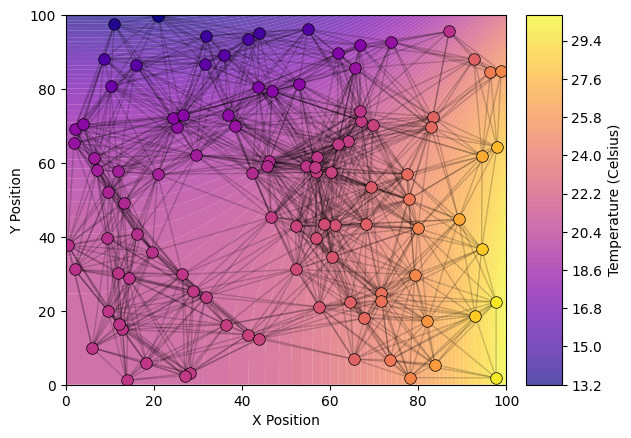

In [13]:
# Set random seed for reproducibiliy
np.random.seed(0)

# Randomly generate sensor locations within the field
sensor_locations = np.array([np.random.uniform(FIELD_RANGE[0,0], FIELD_RANGE[0,1], NUM_SENSORS),
                            np.random.uniform(FIELD_RANGE[1,0], FIELD_RANGE[1,1], NUM_SENSORS)])

# Calculate the adjacency matrix, degree matrix, and Laplacian matrix
adjacency_matrix, degree_matrix, laplacian_matrix = calculate_graph_matrices(sensor_locations, COMM_RANGE)
# Determine if the graph is connected
if not is_graph_connected(laplacian_matrix):
    print("Warning: The graph is not connected.")
else:
    print("The graph is connected.")

# Generate sensor measurements from the field function
noise_std = 0
sensor_measurements = get_sensor_measurements(sensor_locations, field_function, noise_std)
average_temperature = np.mean(sensor_measurements)
print("Average temperature:", "{:.2f}".format(average_temperature), "C")

# Visualize the sensor locations and the communication graph
visualize_graphs(sensor_locations, adjacency_matrix, field_function, sensor_measurements)

**Randomized Gossip**

The optimal P matrix is better than the uniform distribution.


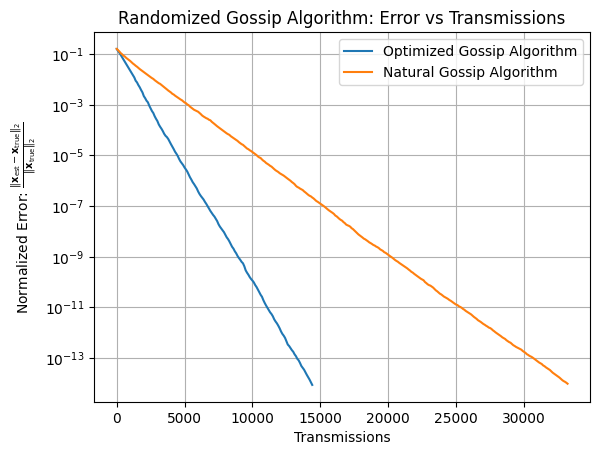

In [49]:
def get_p_matrix(adjacency_matrix):
    n = adjacency_matrix.shape[0]
    W_bar = cvx.Variable((n, n), symmetric=True)
    constraints = [W_bar >> 0]

    Wij_list = []
    for i in range(0, n):
        for j in range(0, n):
            if (adjacency_matrix[i, j] > 0):
                e_i = np.zeros((n, 1)); e_i[i] = 1
                e_j = np.zeros((n, 1)); e_j[j] = 1
                W_ij = np.eye(n) - 0.5 * (e_i - e_j) @ (e_i - e_j).T
                Wij_list.append(W_ij)
                # only add the W_ij corresponding to an existing edge

    Wij_flat = np.array([W.flatten() for W in Wij_list])
    # p - vector -  contains the nonzero entries in P
    p = cvx.Variable(len(Wij_list), nonneg=True)
    W_bar_vec = p @ Wij_flat / n  # CVXPY expression

    # Reshape back to matrix
    W_bar = cvx.reshape(W_bar_vec, (n, n), order='F')

    # Introduce the constraints for P  - > row sum has to be 1
    row_sums = [0] * n
    cnt = 0
    for i in range(n):
        for j in range(n):
            if adjacency_matrix[i, j] > 0:
                row_sums[i] += p[cnt]
                cnt += 1

    for i in range(n):
        constraints.append(row_sums[i] == 1)

    one_vec = np.ones((n, 1))
   # J = np.eye(n) - one_vec @ one_vec.T / n
    W_proj = W_bar - (one_vec @ one_vec.T)/n

    # Minimize the second largest eigenvalue of W_bar by minimizing the largest eigenvalue of W_proj
    obj = cvx.Minimize(cvx.lambda_max(W_proj))

    # define the cvx problem
    prob = cvx.Problem(obj, constraints)
    # SCS solver used for SDP
    prob.solve(solver=cvx.SCS)

    cnt = 0
    P = np.zeros((n,n))
    for i in range(0, n):
        for j in range(0, n):
            if (adjacency_matrix[i, j] > 0):
                # .value we get the value from the cvx variable
                P[i, j] = p[cnt].value
                cnt += 1

    return np.round(P, 4)

# Implements the randomized gossip algorithm for the specified number of iterations
def randomized_gossip(adjacency_matrix, sensor_measurements, P, num_iter):
    num_sensors = adjacency_matrix.shape[0]
    true_average = np.mean(sensor_measurements) * np.ones(num_sensors)
    est_average = sensor_measurements.copy()
    # Initialization of variables
    error_val = calculate_error(est_average, true_average)
    iter  = 0
    error_vals = [error_val]
    iters = [iter]

    while iter < num_iter and error_val > 1e-14:
        # Randomly choose a sensor
        i = np.random.randint(0, num_sensors)
        # Randomly choose a neighbor
        j = np.random.choice(len(P[i]), p=P[i]/sum(P[i]))
        # Compute the average of the two selected sensors
        average_val = 0.5*(est_average[i] + est_average[j])
        # est_average contains the estimates of the average for nodes
        est_average[i] = average_val
        est_average[j] = average_val
        # Calculate the error
        if (iter % 100 == 0):
            error_val = calculate_error(est_average, true_average)
            error_vals.append(error_val)
            iters.append(iter)
        iter += 1

    return error_vals, iters, est_average

# Get the P and W_bar for both natural and optimized averaging
P_opt = get_p_matrix(adjacency_matrix)
P_nat = adjacency_matrix / np.sum(adjacency_matrix, axis=1, keepdims=True)
W_bar1 = get_W_bar(P_opt, adjacency_matrix)
W_bar2 = get_W_bar(P_nat, adjacency_matrix)

# Check that the optimized P matrix performs better
if (np.linalg.eigvalsh(W_bar1)[::-1][1] < np.linalg.eigvalsh(W_bar2)[::-1][1]):
    print("The optimal P matrix is better than the uniform distribution.")
else:
    print("The uniform distribution is better than the optimal P matrix.")

# Get the errors and estimated averages
error_vals1, iters1, est_average1 = randomized_gossip(adjacency_matrix, sensor_measurements, P_opt, 50000)
error_vals2, iters2, est_average2 = randomized_gossip(adjacency_matrix, sensor_measurements, P_nat, 50000)

plt.semilogy(iters1, error_vals1)
plt.semilogy(iters2, error_vals2)

plt.grid(True)
plt.xlabel("Transmissions")
plt.ylabel(r"Normalized Error: $\frac{\|\mathbf{x}_{\mathrm{est}} - \mathbf{x}_{\mathrm{true}}\|_2}{\|\mathbf{x}_{\mathrm{true}}\|_2}$")
plt.title("Randomized Gossip Algorithm: Error vs Transmissions")
plt.legend(["Optimized Gossip Algorithm", "Natural Gossip Algorithm"])

PDMM - Average Consensus

Text(0.5, 1.0, 'PDMM Average Consensus: Error vs Transmissions')

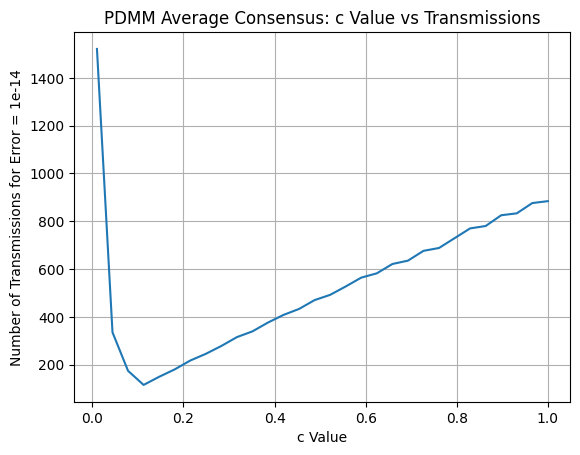

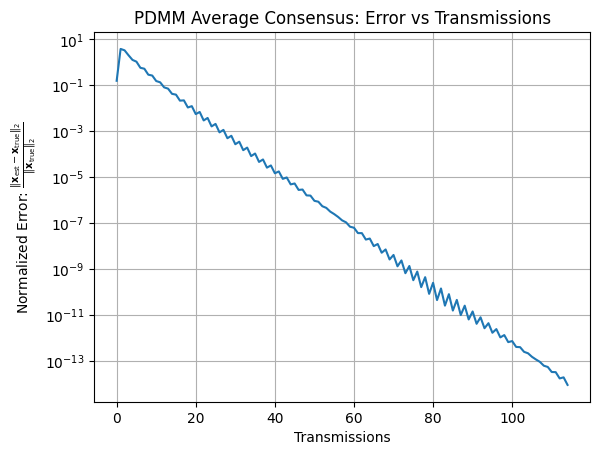

In [51]:
def pdmm_average(adjacency_matrix, sensor_measurements, c, num_iter):
    n = adjacency_matrix.shape[0]
    # Initialize variables
    x = sensor_measurements.copy()
    x_true = np.mean(sensor_measurements) * np.ones(n)
    error_val = calculate_error(x, x_true)
    error_vals = [error_val]
    y = {}
    z = {}
    for i in range(n):
        for j in range(n):
            if adjacency_matrix[i, j] > 0:
                z[(i, j)] = sensor_measurements[i]

    iter = 0
    while iter < num_iter and error_val > 1e-14:

        for i in range(n):
            # x update
            x[i] = sensor_measurements[i]
            # Find neighbors
            neighbors_idx = np.where(adjacency_matrix[i, :] > 0)[0]
            # Loop through neighbors
            for j in neighbors_idx:
                if i < j:
                    A = 1
                else: 
                    A = -1
                x[i] -= A * z[(i, j)]
            x[i] /= (1 + c * len(neighbors_idx))

            # y update 
            for j in neighbors_idx: 
                if i < j:
                    A = 1
                else: 
                    A = -1
                y[(i, j)] = z[(i, j)] + 2 * c * A * x[i]

        # Transmit variables

        # Update auxiliary variables
        for i in range(n):
            neighbors_idx = np.where(adjacency_matrix[i, :] > 0)[0]
            for j in neighbors_idx:
                z[(j, i)] = y[(i, j)]

        # Calculate error
        error_val = calculate_error(x, x_true)
        error_vals.append(error_val)

        iter += 1

    return error_vals, x

# Run PDMM average consensus for different values of c
c_vals = np.linspace(0.01, 1, 30)
num_transmissions = []
for c in c_vals:
    error_vals, x = pdmm_average(adjacency_matrix, sensor_measurements, c, 2000)
    num_transmissions.append(len(error_vals))

fig = plt.figure()  
plt.plot(c_vals, num_transmissions, label='Number of Transmissions')
plt.grid(True)
plt.xlabel("c Value")
plt.ylabel("Number of Transmissions for Error = 1e-14")
plt.title("PDMM Average Consensus: c Value vs Transmissions")

# Get the best value of c and plot the error
best_c = c_vals[np.argmin(num_transmissions)]
error_vals, x = pdmm_average(adjacency_matrix, sensor_measurements, best_c, 2000)

fig = plt.figure()
plt.semilogy(error_vals, label=f'c={c:.2f}')
plt.grid(True)
plt.xlabel("Transmissions")
plt.ylabel(r"Normalized Error: $\frac{\|\mathbf{x}_{\mathrm{est}} - \mathbf{x}_{\mathrm{true}}\|_2}{\|\mathbf{x}_{\mathrm{true}}\|_2}$")
plt.title("PDMM Average Consensus: Error vs Transmissions")